In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import cv2
import math
import time

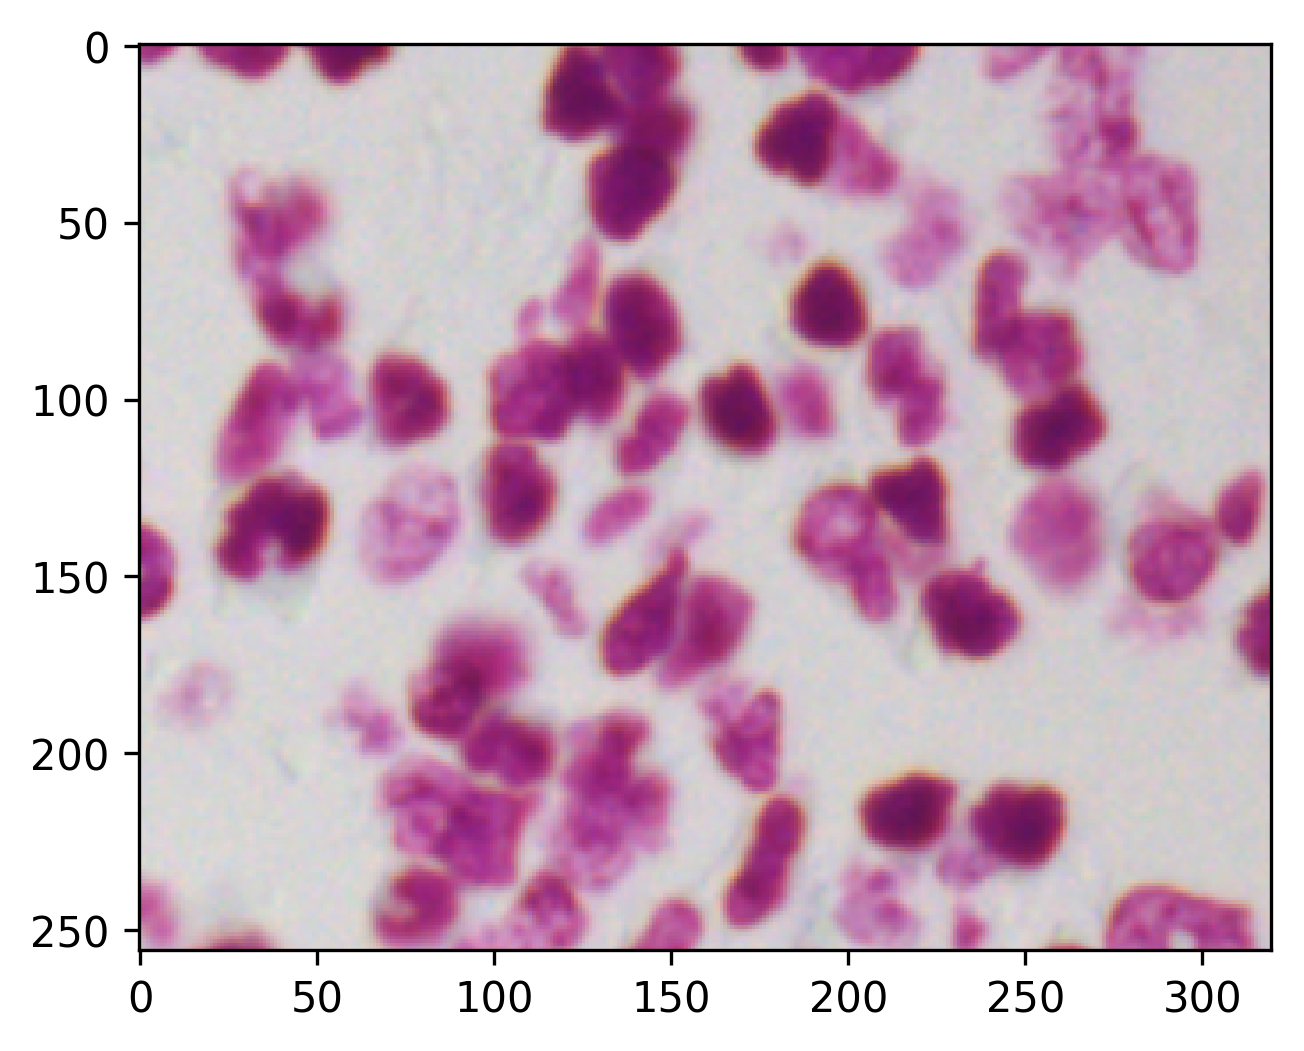

In [2]:
img = cv2.imread('speci2.png')
plt.rcParams['figure.dpi'] = 300
plt.imshow(img)

In [3]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
magni,angle = cv2.cartToPolar(sobelx,sobely)

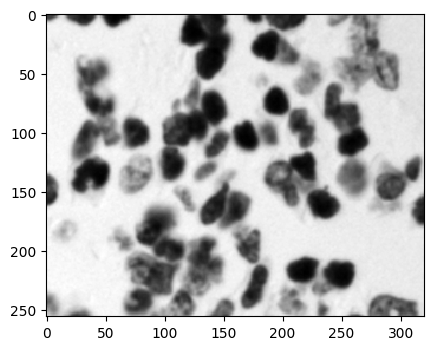

In [8]:
plt.rcParams['figure.dpi'] = 100
plt.imshow(gray,cmap='gray')

In [16]:
mask = gray < 180

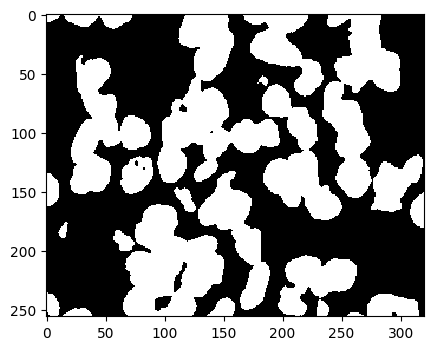

In [17]:
plt.rcParams['figure.dpi'] = 100
plt.imshow(mask,cmap='gray')

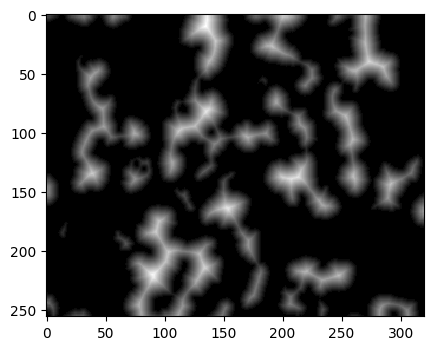

In [24]:
distance_map = cv2.distanceTransform(mask.astype(np.uint8),cv2.DIST_L2,5)
plt.rcParams['figure.dpi'] = 100
plt.imshow(distance_map,cmap='gray')

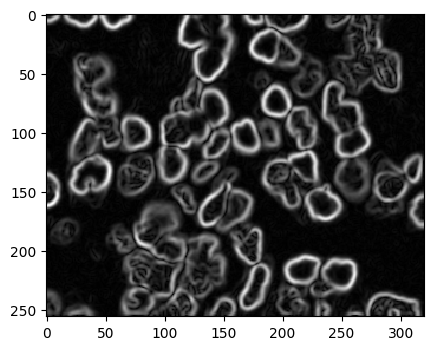

In [29]:
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
magni,angle = cv2.cartToPolar(sobelx,sobely)
plt.rcParams['figure.dpi'] = 100
plt.imshow(magni,cmap = 'gray')

In [34]:
h,w = magni.shape
magni_th = magni.mean()+200

In [41]:
def default_weight(*args):
    return 1

def gauss_weight(y,x,center_y,center_x,sigma):
    s = 2*(sigma)**2
    index = -1*((x-center_x)**2+(y-center_y)**2)/s
    weight = math.exp(index)/(s*math.pi)
    return weight

_delta = 30*math.pi/180

def get_area_templates(rmin,rmax,d=_delta,weight=default_weight):
    area_templates = []
    num = 360
    if rmax < 30:
        num = 180
    elif rmax < 15:
        num = 90
    
    radio = 2*math.pi/num
    for i in range(0,num):
        init_area = np.zeros((rmax*2+1,rmax*2+1))
        orient = i*radio
        y = rmax
        x = rmax
        center_y = math.floor(y+((rmin+rmax)/2)*math.sin(orient))
        center_x = math.floor(x+((rmin+rmax)/2)*math.cos(orient))
        for p in range(0,2*rmax+1):
            for q in range(0,2*rmax+1):
                dist = (p-x)**2+(q-y)**2
                if dist > rmin**2 and dist < rmax**2 :
                    vec_angle = math.atan2(q-y,p-x)
                    if vec_angle < 0:
                        vec_angle += math.pi*2
                    angle_diff = abs(vec_angle - orient)
                    if  angle_diff <= d  or angle_diff >= 2*math.pi-d:
                        init_area[q][p] = 1*weight(q,p,center_y,center_x,(rmax-rmin)/2)
                else:
                    continue
        
        area_templates.append(init_area)
    
    return area_templates


def v_a_from_templates(y,x,area_templates,angle):
    orient = (angle[y][x]+math.pi)%(2*math.pi)
    radio =  2*math.pi/len(area_templates)
    index = math.floor((orient/radio)+0.5)
    index = index%len(area_templates) #radius [359.5,360)
    voting_area = np.zeros_like(angle)
    sample = area_templates[index].copy()
    _,lenth = sample.shape
    rmax = (lenth-1)//2
    move_y = rmax-y
    move_x = rmax-x
    
    x_low = max(x-rmax,0)
    x_high = min(x+rmax,w)
    y_low = max(y-rmax,0)
    y_high = min(y+rmax,h)

    s_x_l = x_low + move_x
    s_x_h = x_high + move_x
    s_y_l = y_low + move_y
    s_y_h = y_high + move_y


    voting_area[y_low:y_high,x_low:x_high] = sample[s_y_l:s_y_h,s_x_l:s_x_h]

    return voting_area
    


In [37]:
area_templates = get_area_templates(5,15,weight=gauss_weight)

In [42]:
result = []
st = time.time()
for i in range(w):
    for j in range(h):
        if magni[j][i] > magni_th:
            result.append(v_a_from_templates(j,i,area_templates,angle)*distance_map[j][i])
et = time.time()
print(et-st)

9.63352108001709


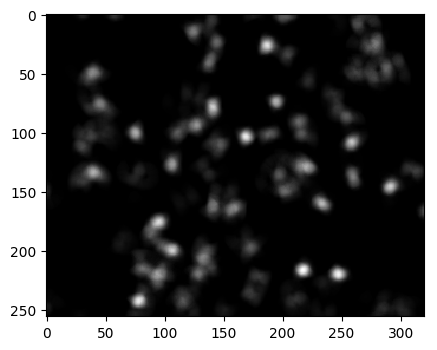

In [43]:
voting_area = np.zeros_like(magni)
for i in range(len(result)):
    voting_area += result[i]
plt.rcParams['figure.dpi'] = 100
plt.imshow(voting_area,cmap = 'gray')

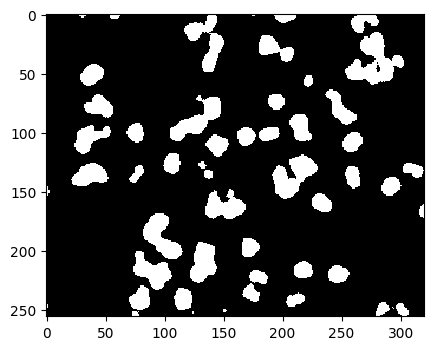

In [69]:
seed_th = voting_area.max()*0.1
th_voting = np.copy(voting_area)
th_voting[th_voting<seed_th] = 0
th_voting[th_voting>= seed_th] = 1
plt.rcParams['figure.dpi'] = 100
plt.imshow(th_voting,cmap = 'gray')

In [76]:
voting_area.max()

8.3565173672997695

In [55]:
def mean_shift(src,bandwidth):
    flags = np.zeros_like(src)
    h,w = src.shape

    def get_center(cy,cx):
        xl = max(0,cx-bandwidth)
        xh = min(w,cx+bandwidth)
        yl = max(0,cy-bandwidth)
        yh = min(h,cy+bandwidth)
        count = 0
        x_sum = 0
        y_sum = 0
        for p in range(xl,xh):
            for q in range(yl,yh):
                num = src[q][p]
                count += num
                x_sum += num*p
                y_sum += num*q
        if count == 0:
            return cy,cx,count
        else:
            mean_y = math.floor(y_sum / count + 0.5)
            mean_x = math.floor(x_sum / count + 0.5)
            return mean_y, mean_x,count
    
    seeds = []
    
    for i in range(w):
        for j in range(h):
            if flags[j][i] == 1 :
                continue
            x = i
            y = j
            while True:
                y_m,x_m,c = get_center(y,x)
                if flags[y_m][x_m] == 1:
                    break
                if y_m == y and x_m == x :
                    flags[y_m][x_m] =1
                    if c > 0:
                        seeds.append((y_m,x_m))
                    break
                y = y_m
                x = x_m

    return seeds

In [73]:
s_t = time.time()
th_voting = np.copy(voting_area)
seed_th = voting_area.max() *0.1
th_voting[th_voting<seed_th] = 0
final_seeds = mean_shift(th_voting,9)
e_t = time.time()
print(e_t-s_t)

63.33867359161377


In [74]:
len(final_seeds)

233

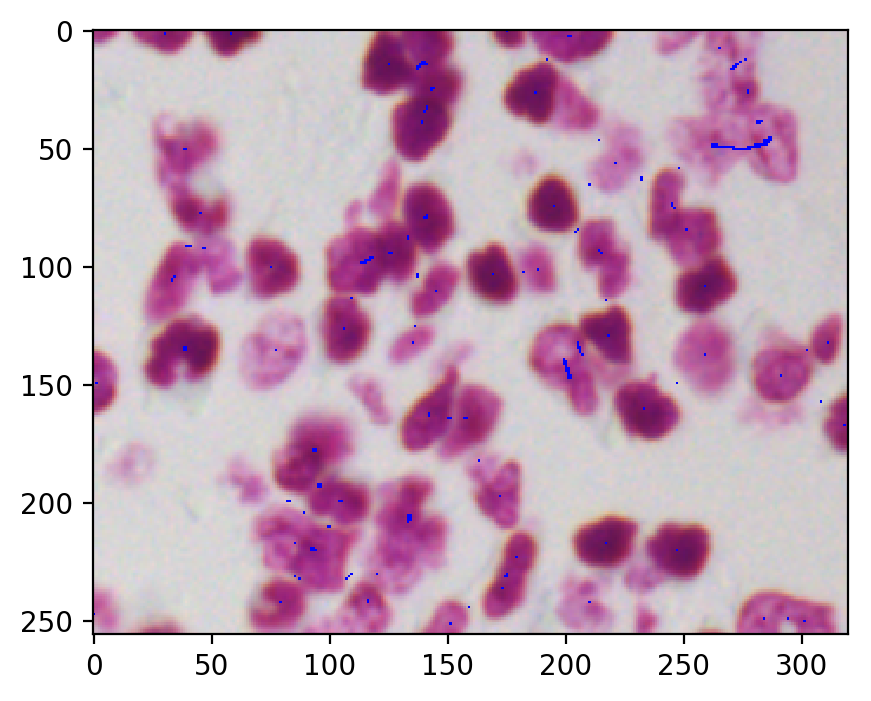

In [75]:
show_img = cv2.imread('speci2.png')
for i in range(len(final_seeds)):
    coord = final_seeds[i]
    y = math.floor(coord[0])
    x = math.floor(coord[1])
    show_img[y][x] = [0,0,255]
plt.rcParams['figure.dpi'] = 200
plt.imshow(show_img)